In [3]:
import requests
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
print(torch.__version__)

2.1.0+cu121


In [4]:
device="cuds" if torch.cuda.is_available() else "gpu"
print(f"using device:{device}")

using device:gpu


In [5]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


1) Get Data:  Food classification :Food101
but we are goint to use dataset which has only 3 claasses and 100 images per class

In [6]:
# create a directory for downloading the dataset
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"
# if image folder doesn't exists, download it and prepare it

if image_path.is_dir():
  print(f"{image_path}  directory already exists..skipping download")
else:
  print(f"{image_path}  directory does not exists exists..creating one")
  image_path.mkdir(parents=True, exist_ok=True)
# download pizza_steak_sushi data

with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading data")
  f.write(request.content)

# unzipping the zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("unzipping pizza_steak_sushi data")
  zip_ref.extractall(path=image_path)



data/pizza_steak_sushi  directory does not exists exists..creating one
downloading data
unzipping pizza_steak_sushi data


Exploreing the data

In [7]:
import os
# print(list(os.walk(data_path/"pizza_steak_sushi")))

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(data_path/"pizza_steak_sushi"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(data_path/"pizza_steak_sushi")

there are 2 directories and 0 images in data/pizza_steak_sushi.
there are 3 directories and 0 images in data/pizza_steak_sushi/test.
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
there are 3 directories and 0 images in data/pizza_steak_sushi/train.
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.


In [8]:
# setup training and testing paths
train_dir=image_path/"train"
test_dir=image_path/"test"
print(train_dir, test_dir)

data/pizza_steak_sushi/train data/pizza_steak_sushi/test


### visualizing data
Steps 1) get all images path
2) pick random images  random.choices()
3) get the image class name using "pathlib.Path.parent.stem
4) since we are working with imahges, lets open imagw woth Pythion's PIL library

In [9]:
image_path

PosixPath('data/pizza_steak_sushi')

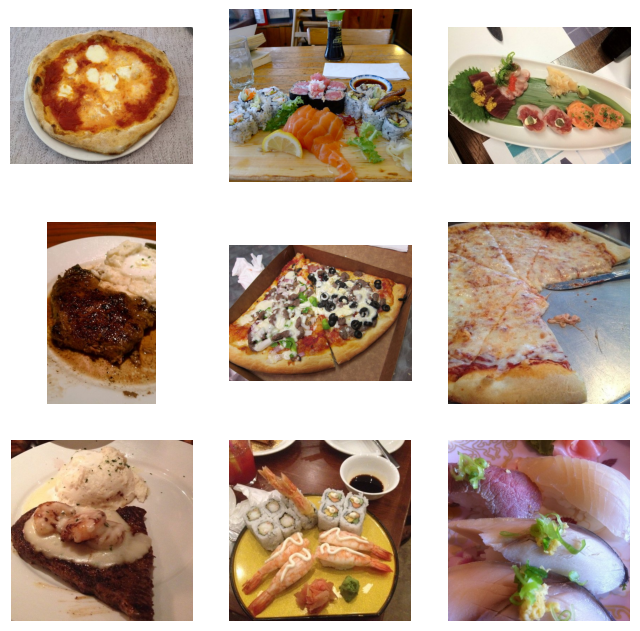

In [10]:
import random
import PIL
import glob
from PIL import Image
from matplotlib import pyplot as plt

random.seed(42)
images_paths=glob.glob(pathname=rf"{image_path}/*/*/*.jpg")
random_images_paths=random.choices(images_paths,k=9)
fig = plt.figure(figsize=(8, 8))
for index, path in enumerate(random_images_paths):
  image=Image.open(path)
  ax=fig.add_subplot(3,3,index+1)
  ax.imshow(image)
  ax.axis("off")
plt.show()

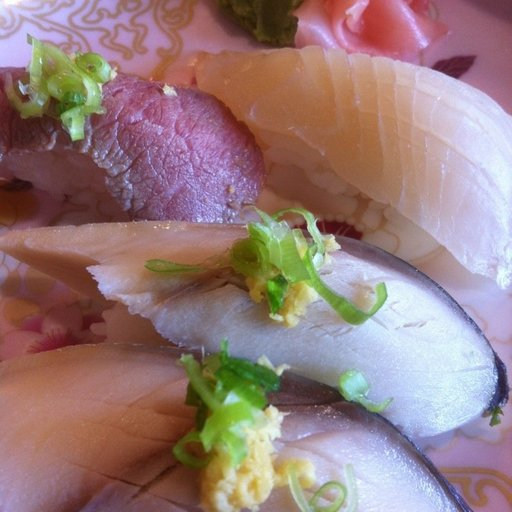

In [11]:
image

array([[[227, 222, 242],
        [232, 225, 243],
        [237, 229, 244],
        ...,
        [100,  54,  67],
        [100,  54,  67],
        [101,  55,  68]],

       [[235, 230, 250],
        [237, 233, 250],
        [241, 233, 248],
        ...,
        [100,  54,  67],
        [ 99,  53,  66],
        [ 98,  52,  65]],

       [[241, 238, 255],
        [241, 238, 255],
        [243, 237, 251],
        ...,
        [ 99,  53,  66],
        [ 98,  52,  65],
        [ 96,  50,  63]],

       ...,

       [[157, 131, 178],
        [159, 133, 180],
        [160, 134, 182],
        ...,
        [160, 108, 131],
        [156, 104, 126],
        [153, 102, 121]],

       [[155, 127, 175],
        [158, 130, 178],
        [159, 133, 181],
        ...,
        [159, 110, 132],
        [158, 106, 128],
        [155, 103, 125]],

       [[153, 125, 173],
        [157, 129, 177],
        [161, 135, 183],
        ...,
        [160, 111, 133],
        [159, 107, 130],
        [157, 105, 127]]], dtype=uint8)
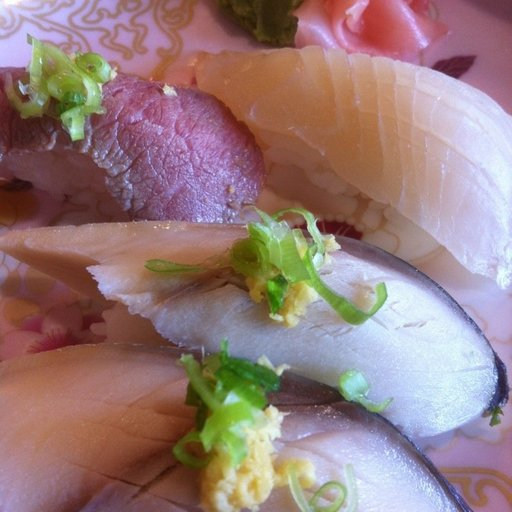

In [12]:
import numpy as np
img_array=np.asarray(image)
img_array

### Tranaforming our data into tensor format
1. turn target data into tensots
2. turn it into "torch.utils.data.Dataset and subsequently torch.utils.data
---



In [13]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# transforming data using transfors

In [14]:
data_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5), # filp the image on the horizontal
    # turn thr image into torcch tensor
    transforms.ToTensor()
])

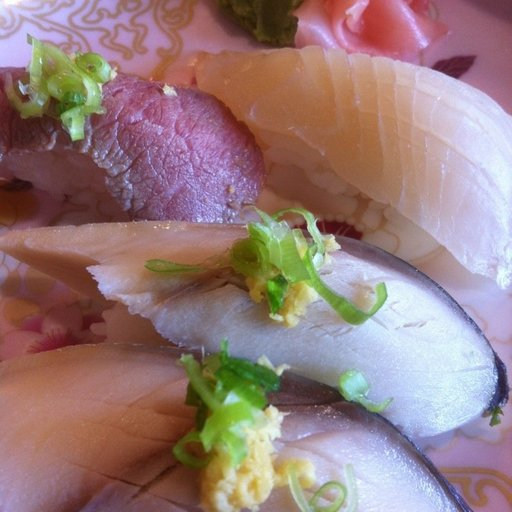

In [15]:
image

In [16]:
img_transformed=data_transforms(image)

In [18]:
def plot_transformed_images(image_paths: list, transforms, n=3, seed=None):
  """
  Selects random images from the path of images and loads/transforms them then plots original vs transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(images_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplot(nrows=1, ncols=2)
      #plot original
      ax[0].imshow(f)
      ax[0].set_title(f"original\nSize:{f.size}")
      ax[0].axis("offf")
      # plot transformed
      transformed_image=transforms(f) # this changes the shape, c,h,w, but matplotlib supports h,w,c
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed\nsize :{transformed_image.shape}")
      ax[1].axis("off")








In [21]:
plot_transformed_images(image_paths=images_paths,transforms=data_transforms,n=3, seed=42)

TypeError: subplot() got an unexpected keyword argument 'ncols' and/or 'nrows'.  Did you intend to call subplots()?